In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from s2sphere import CellId
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Load token stream
data_df = pd.read_csv('data/S2Cell_ID_level16.csv', usecols=[2], names=["S2_Cell_ID"], header=0)
vocab_df = pd.read_csv('data/uniqueS2s_level16.csv', names=["Token"])

data = list(map(int, data_df['S2_Cell_ID'].astype(str).str.strip()))
vocab_tokens = list(map(int, vocab_df['Token'].astype(str).str.strip()))

id_to_idx = {token: idx for idx, token in enumerate(vocab_tokens)}
indexed_data = [id_to_idx[cell_id] for cell_id in data if cell_id in id_to_idx]

data_tensor = torch.tensor(indexed_data, dtype=torch.long)
n = int(0.8 * len(data_tensor))
train_data = data_tensor[:n]
val_data = data_tensor[n:]

print("Data points:", len(indexed_data), "| Vocab size:", len(vocab_tokens))



Data points: 967089 | Vocab size: 103244


In [3]:
def get_batch(data, block_size, batch_size):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)


In [4]:
class SpatialGPT(nn.Module):
    def __init__(self, vocab_size, n_embd=256, n_layer=6, n_head=4, block_size=64):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.pos_embedding = nn.Parameter(torch.zeros(1, block_size, n_embd))
        self.transformer = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(d_model=n_embd, nhead=n_head, batch_first=True),
            num_layers=n_layer
        )
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        B, T = x.size()
        tok_emb = self.token_embedding(x)
        pos_emb = self.pos_embedding[:, :T, :]
        x = tok_emb + pos_emb
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(x.device)
        x = self.transformer(x, x, tgt_mask=tgt_mask)
        x = self.ln_f(x)
        return self.head(x)


In [5]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_spatial_gpt(
    model,
    train_data,
    val_data,
    vocab_tokens,
    block_size=64,
    batch_size=32,
    steps=25001,
    eval_interval=1000,
    sample_interval=5000,
    checkpoint_path="spatial_gpt.pt"
):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)
    loss_fn = nn.CrossEntropyLoss()

    train_losses, val_losses, times = [], [], []
    start_time = time.time()

    def get_batch(data):
        ix = torch.randint(len(data) - block_size, (batch_size,))
        x = torch.stack([data[i:i+block_size] for i in ix])
        y = torch.stack([data[i+1:i+block_size+1] for i in ix])
        return x.to(device), y.to(device)

    def evaluate(data):
        model.eval()
        xb, yb = get_batch(data)
        with torch.no_grad():
            logits = model(xb)
            loss = loss_fn(logits.view(-1, logits.size(-1)), yb.view(-1)).item()
        return loss

    def generate_sample():
        model.eval()
        start = torch.randint(0, len(train_data) - block_size, (1,))
        seed = train_data[start:start+block_size].unsqueeze(0).to(device)
        for _ in range(20):
            logits = model(seed[:, -block_size:])
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            seed = torch.cat([seed, next_token], dim=1)
        return seed[0].tolist()

    def plot_losses():
        plt.figure(figsize=(10, 4))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel("Evaluation Steps")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss")
        plt.grid(True)
        plt.show()

    for step in tqdm(range(steps)):
        model.train()
        xb, yb = get_batch(train_data)
        logits = model(xb)
        loss = loss_fn(logits.view(-1, logits.size(-1)), yb.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % eval_interval == 0:
            train_loss = loss.item()
            val_loss = evaluate(val_data)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            times.append(time.time() - start_time)
            print(f"\nStep {step} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {times[-1]:.2f}s")
            plot_losses()

        if step % sample_interval == 0 and step > 0:
            tokens = generate_sample()
            s2_ids = [vocab_tokens[tok] for tok in tokens]
            print(f"\n[Sample @ step {step}]: {s2_ids[:10]}...")

        if step % 5000 == 0 and step > 0:
            torch.save(model.state_dict(), checkpoint_path)
            print(f"[Checkpoint] Model saved at step {step} -> {checkpoint_path}")

    torch.save(model.state_dict(), checkpoint_path)
    print(f"\n[Final] Model saved -> {checkpoint_path}")

    return train_losses, val_losses, times


  0%|          | 0/25001 [00:00<?, ?it/s]


Step 0 | Train Loss: 11.7115 | Val Loss: 11.7214 | Time: 0.88s


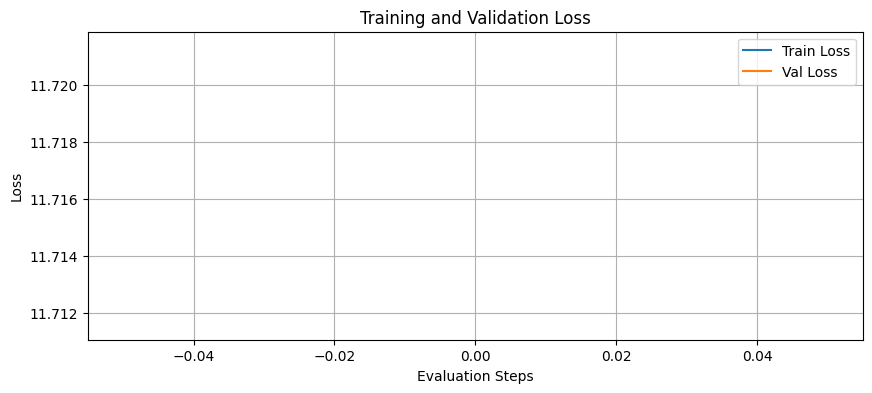

  4%|▍         | 1000/25001 [02:09<50:38,  7.90it/s]


Step 1000 | Train Loss: 10.1535 | Val Loss: 10.8566 | Time: 129.33s


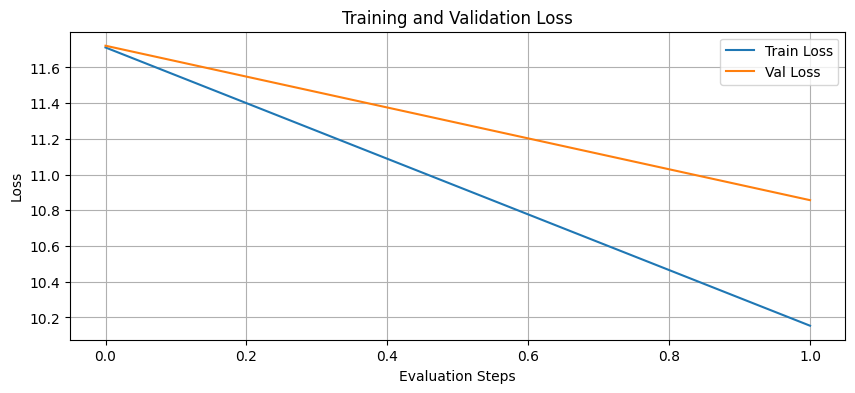

  8%|▊         | 2000/25001 [04:17<45:45,  8.38it/s]  


Step 2000 | Train Loss: 9.6802 | Val Loss: 10.9796 | Time: 257.62s


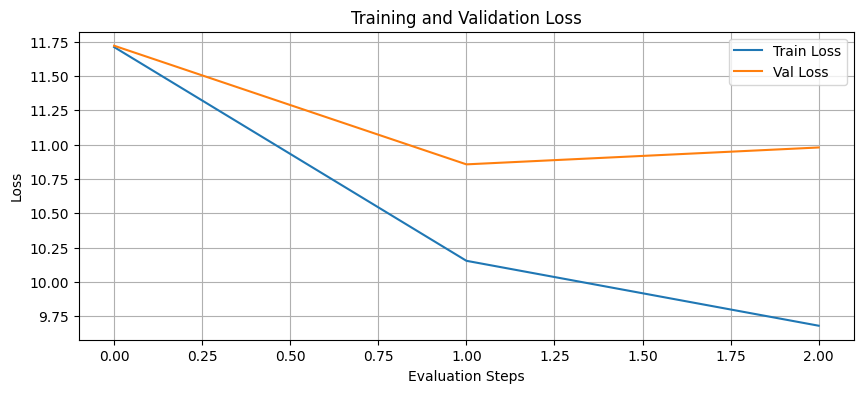

 12%|█▏        | 3000/25001 [06:22<46:20,  7.91it/s]  


Step 3000 | Train Loss: 9.4386 | Val Loss: 10.7233 | Time: 382.75s


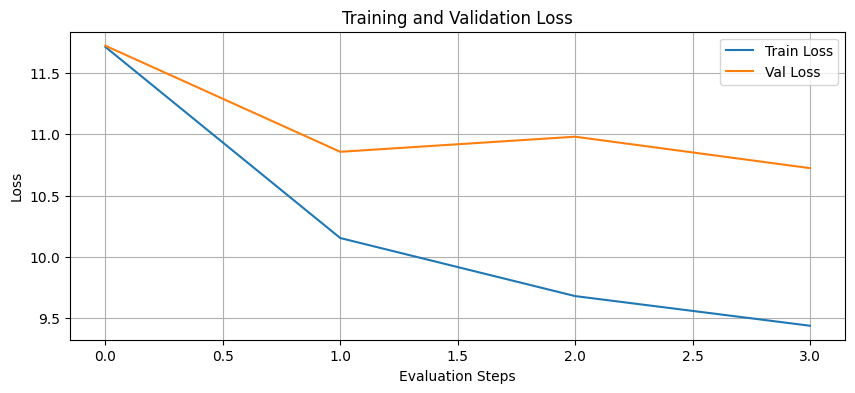

 16%|█▌        | 4000/25001 [08:27<42:48,  8.18it/s]  


Step 4000 | Train Loss: 8.8545 | Val Loss: 10.9040 | Time: 507.96s


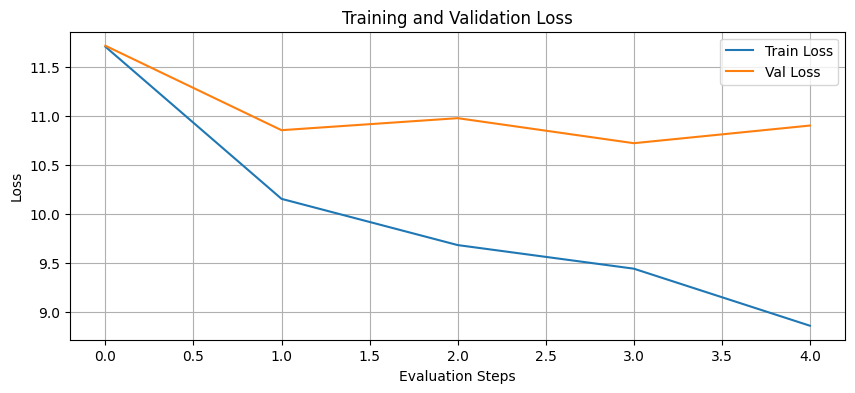

 20%|█▉        | 5000/25001 [10:36<42:54,  7.77it/s]  


Step 5000 | Train Loss: 8.2235 | Val Loss: 10.7913 | Time: 637.13s


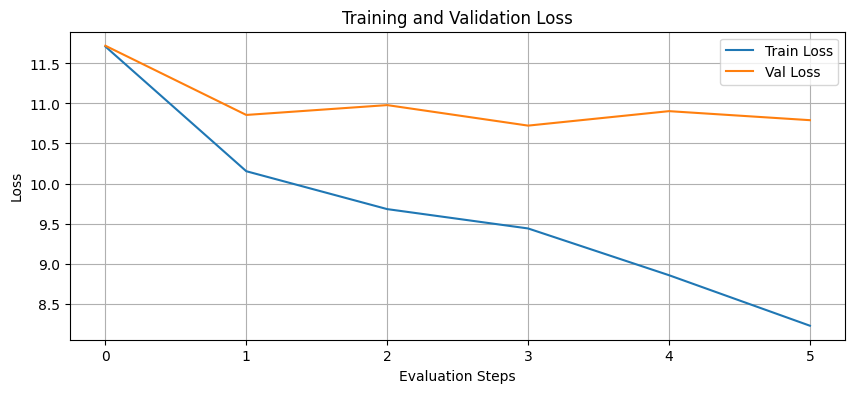


[Sample @ step 5000]: [12006497221831819264, 12686079233210974208, 11913517259936497664, 12687537647875260416, 12686105698262581248, 12006326929599758336, 12006429464427757568, 12686482628350574592, 12687525373932470272, 12687522095261810688]...


 20%|██        | 5002/25001 [10:40<4:10:09,  1.33it/s]

[Checkpoint] Model saved at step 5000 -> spatial_gpt.pt


 24%|██▍       | 6000/25001 [12:47<39:29,  8.02it/s]  


Step 6000 | Train Loss: 7.8708 | Val Loss: 11.0261 | Time: 768.05s


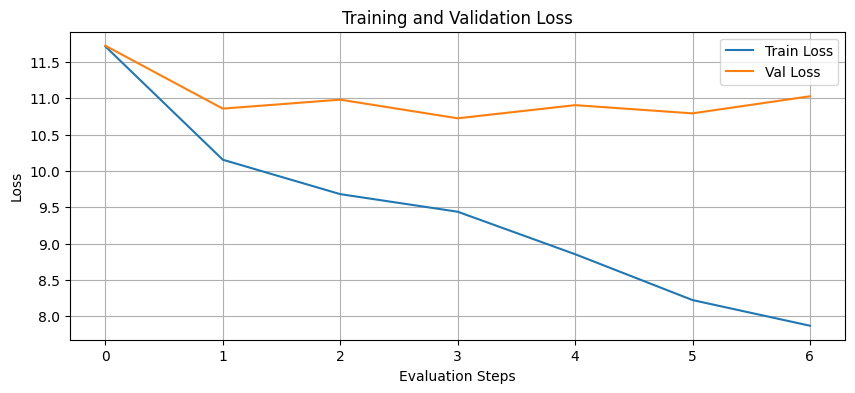

 28%|██▊       | 7000/25001 [14:55<37:44,  7.95it/s]  


Step 7000 | Train Loss: 7.3780 | Val Loss: 10.9781 | Time: 895.38s


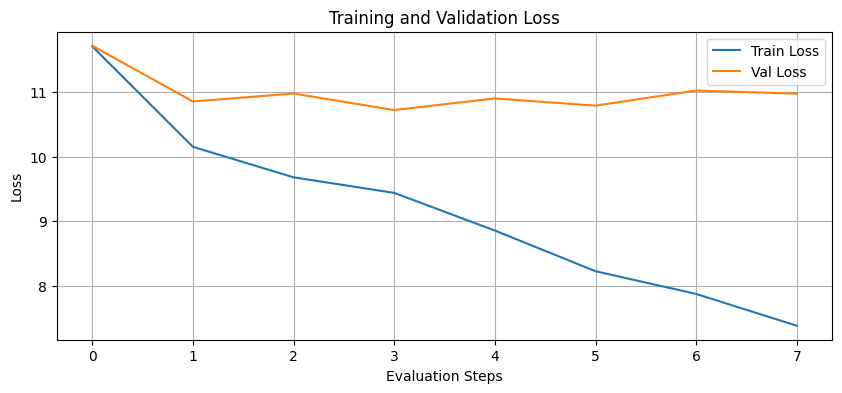

 32%|███▏      | 8000/25001 [17:02<35:46,  7.92it/s]  


Step 8000 | Train Loss: 6.9616 | Val Loss: 11.3097 | Time: 1022.42s


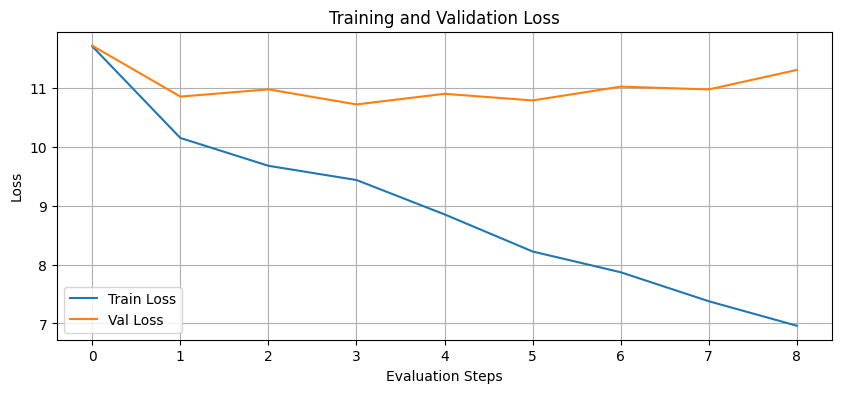

 36%|███▌      | 9000/25001 [19:09<34:02,  7.83it/s]  


Step 9000 | Train Loss: 6.8396 | Val Loss: 11.3312 | Time: 1149.99s


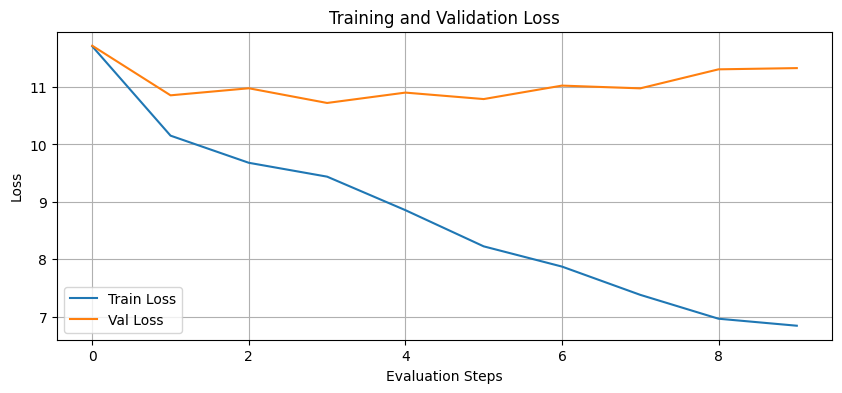

 40%|███▉      | 10000/25001 [21:20<32:06,  7.79it/s] 


Step 10000 | Train Loss: 6.2245 | Val Loss: 11.5467 | Time: 1280.27s


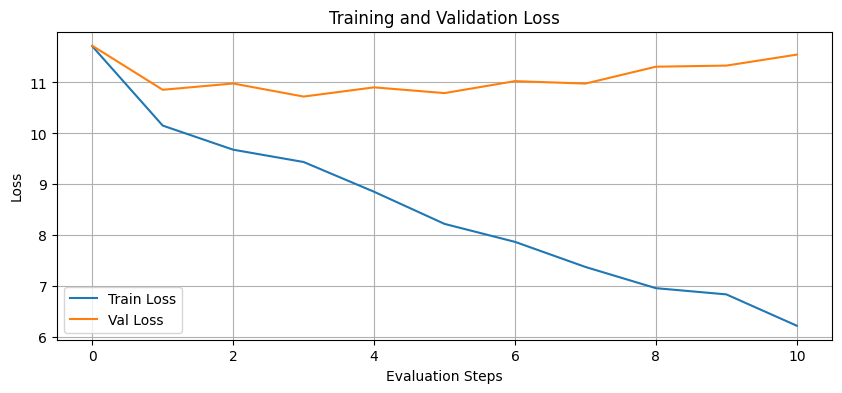


[Sample @ step 10000]: [11831254467657859072, 12686489424062578688, 12686493885459857408, 12711866396707913728, 12711827643218001920, 12686489683371229184, 12687452648324988928, 12711865043256344576, 12687537110467477504, 12687480856596447232]...


 40%|████      | 10002/25001 [21:22<2:37:05,  1.59it/s]

[Checkpoint] Model saved at step 10000 -> spatial_gpt.pt


 44%|████▍     | 11000/25001 [23:32<28:33,  8.17it/s]  


Step 11000 | Train Loss: 5.9367 | Val Loss: 11.5820 | Time: 1412.30s


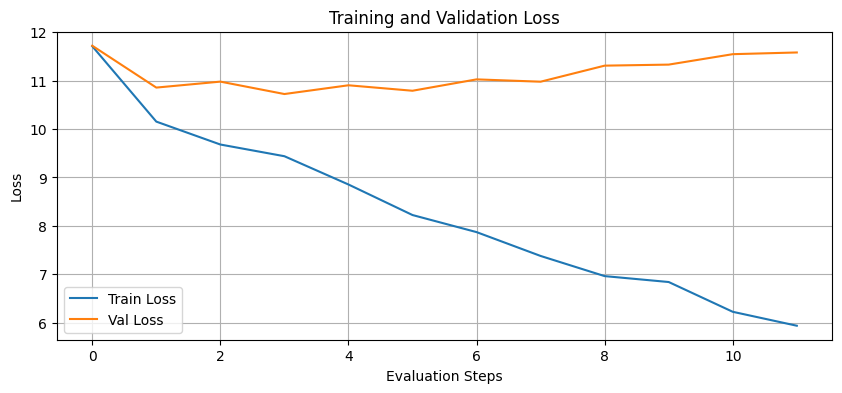

 48%|████▊     | 12000/25001 [25:39<27:08,  7.98it/s]


Step 12000 | Train Loss: 5.8214 | Val Loss: 11.7211 | Time: 1539.82s


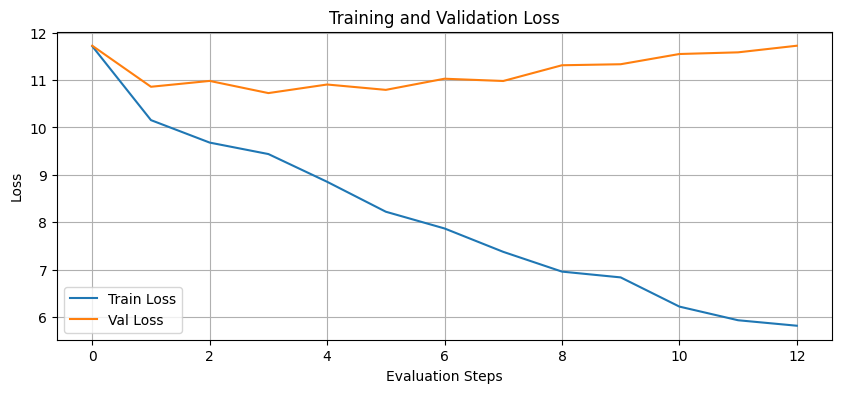

 52%|█████▏    | 13000/25001 [27:47<26:14,  7.62it/s]


Step 13000 | Train Loss: 5.6368 | Val Loss: 11.7292 | Time: 1668.24s


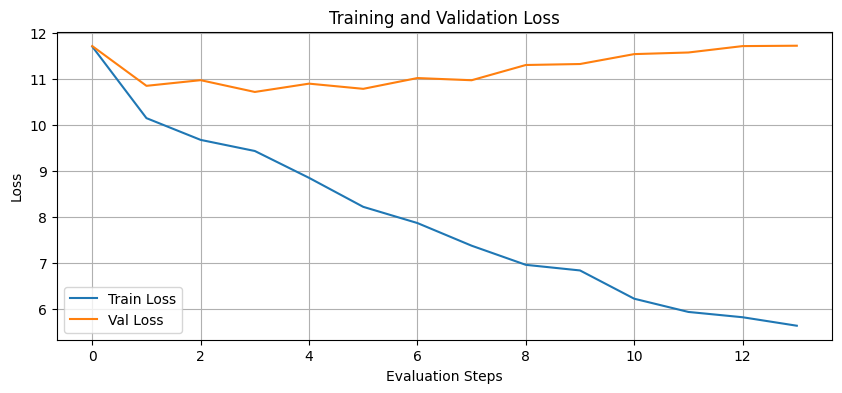

 56%|█████▌    | 14000/25001 [29:56<23:42,  7.73it/s]


Step 14000 | Train Loss: 5.2450 | Val Loss: 11.8497 | Time: 1797.22s


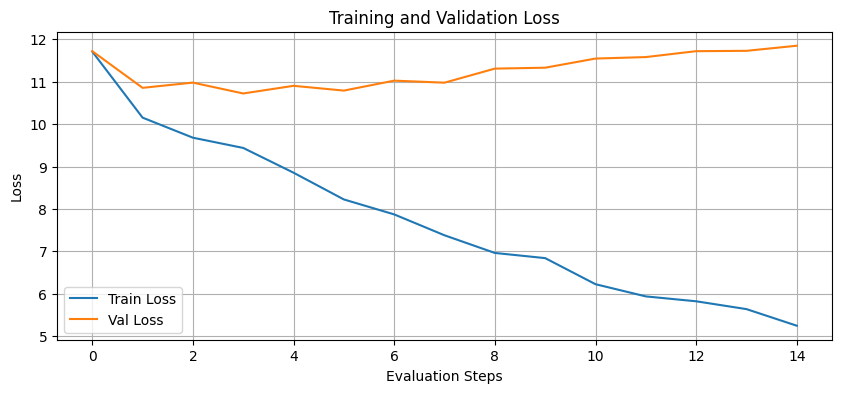

 60%|█████▉    | 15000/25001 [32:04<21:09,  7.88it/s]


Step 15000 | Train Loss: 5.1751 | Val Loss: 12.2181 | Time: 1924.85s


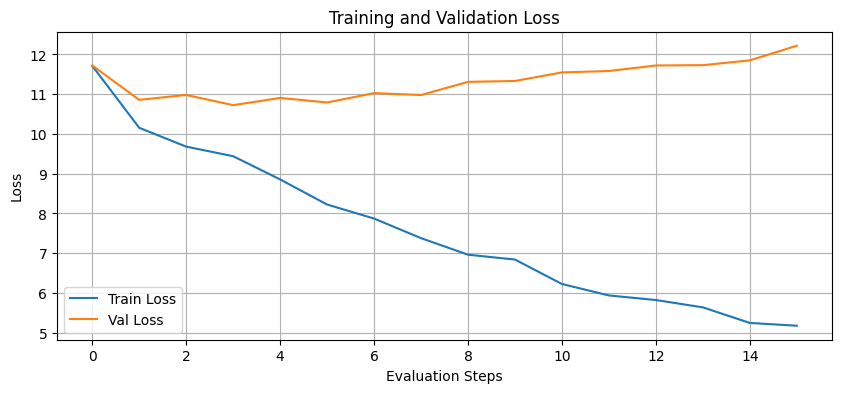


[Sample @ step 15000]: [11831262713995067392, 12708403671667310592, 12687517524342865920, 12006413056042074112, 12687451960056479744, 12687480924779053056, 12687517628495822848, 12708337660704325632, 12006515914066362368, 12711865199485779968]...


 60%|██████    | 15002/25001 [32:07<1:44:23,  1.60it/s]

[Checkpoint] Model saved at step 15000 -> spatial_gpt.pt


 64%|██████▍   | 16000/25001 [34:14<19:07,  7.84it/s]  


Step 16000 | Train Loss: 4.9684 | Val Loss: 12.1020 | Time: 2055.08s


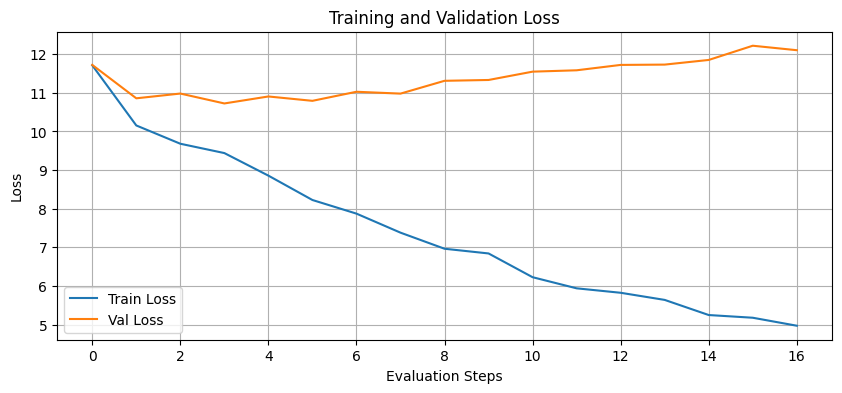

 68%|██████▊   | 17000/25001 [36:23<17:01,  7.83it/s]


Step 17000 | Train Loss: 5.0032 | Val Loss: 12.2416 | Time: 2184.19s


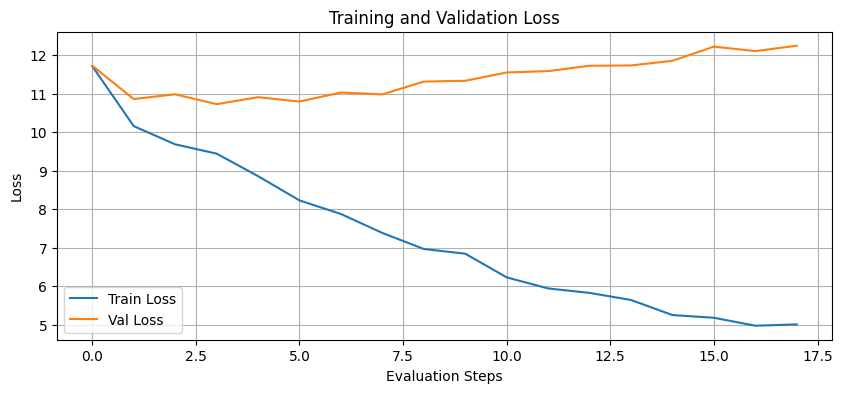

 72%|███████▏  | 18000/25001 [38:32<15:28,  7.54it/s]


Step 18000 | Train Loss: 4.8986 | Val Loss: 12.2572 | Time: 2312.77s


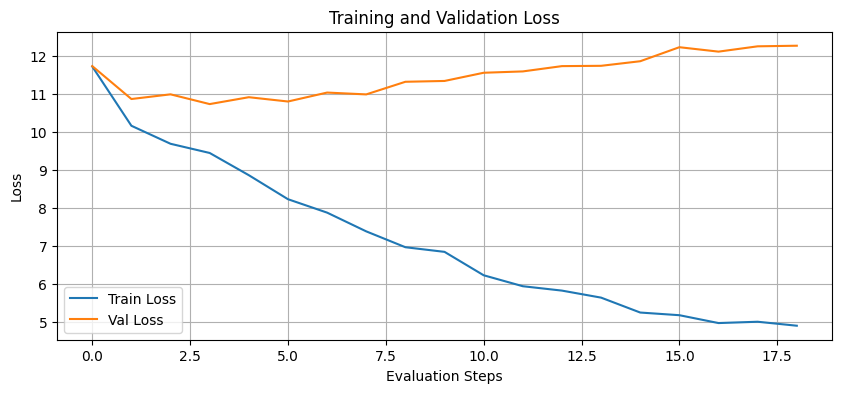

 76%|███████▌  | 19000/25001 [40:41<12:32,  7.98it/s]


Step 19000 | Train Loss: 4.7886 | Val Loss: 12.3125 | Time: 2441.62s


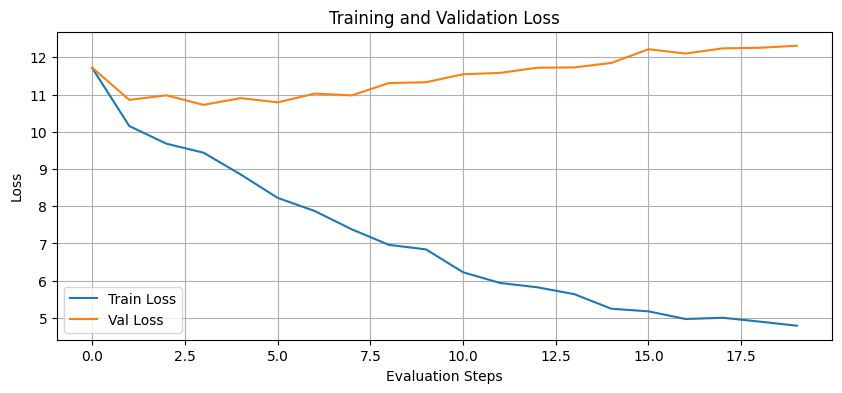

 80%|███████▉  | 20000/25001 [42:49<10:37,  7.84it/s]


Step 20000 | Train Loss: 4.6871 | Val Loss: 12.2166 | Time: 2569.87s


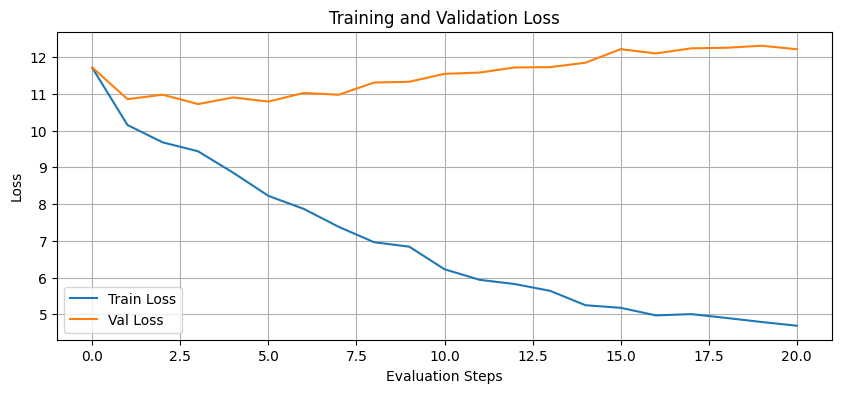


[Sample @ step 20000]: [12687539276741607424, 11831257815584866304, 12708430851830972416, 12687524754920308736, 11831254611539263488, 12687524040881995776, 12687481046648750080, 12687521785487294464, 11831259523908108288, 12686493356105138176]...


 80%|████████  | 20002/25001 [42:52<1:04:29,  1.29it/s]

[Checkpoint] Model saved at step 20000 -> spatial_gpt.pt


 84%|████████▍ | 21000/25001 [45:00<08:38,  7.72it/s]  


Step 21000 | Train Loss: 4.5366 | Val Loss: 12.3091 | Time: 2700.75s


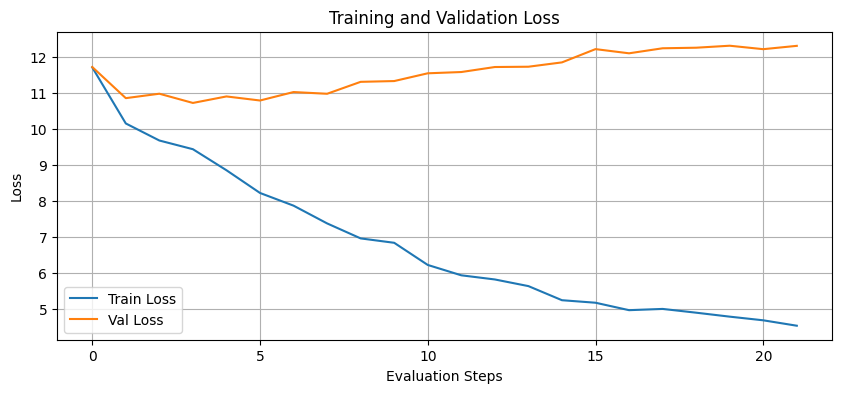

 88%|████████▊ | 22000/25001 [47:08<06:16,  7.97it/s]


Step 22000 | Train Loss: 4.6780 | Val Loss: 12.3827 | Time: 2828.35s


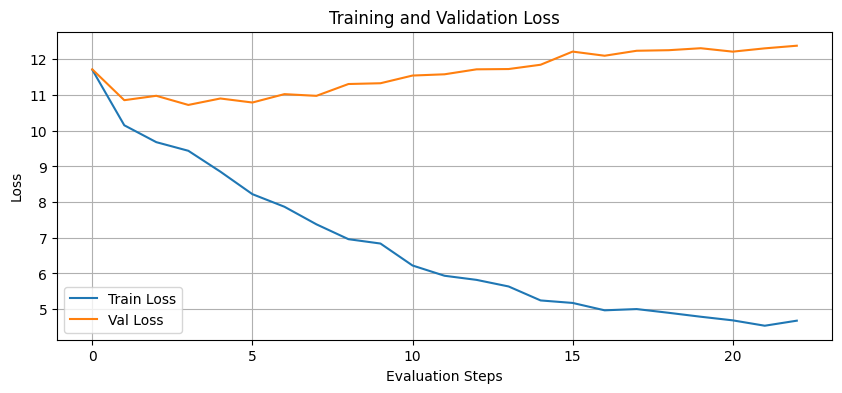

 92%|█████████▏| 23000/25001 [49:15<04:15,  7.83it/s]


Step 23000 | Train Loss: 4.7936 | Val Loss: 12.4807 | Time: 2955.77s


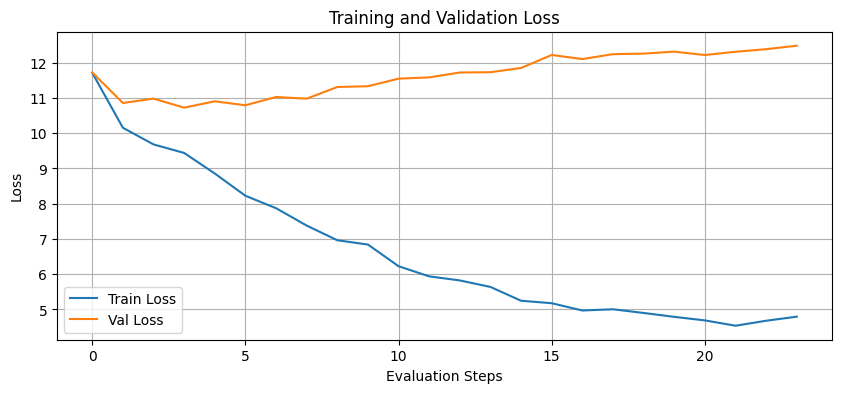

 96%|█████████▌| 24000/25001 [51:23<02:10,  7.67it/s]


Step 24000 | Train Loss: 4.6572 | Val Loss: 12.4891 | Time: 3083.56s


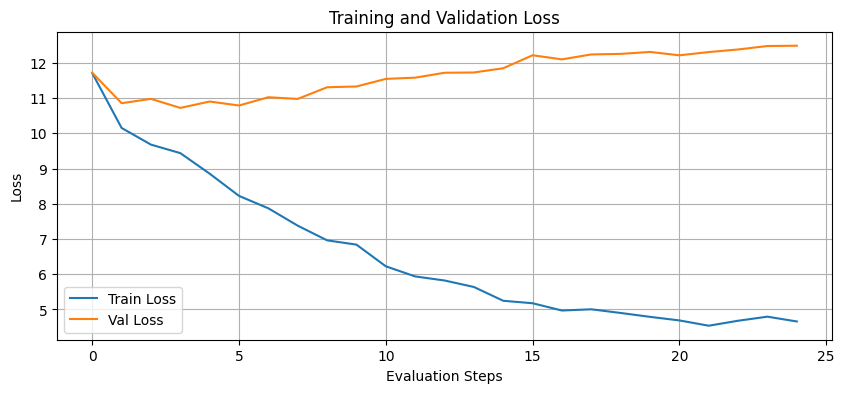

100%|█████████▉| 25000/25001 [53:31<00:00,  8.02it/s]


Step 25000 | Train Loss: 4.5969 | Val Loss: 12.4125 | Time: 3212.20s


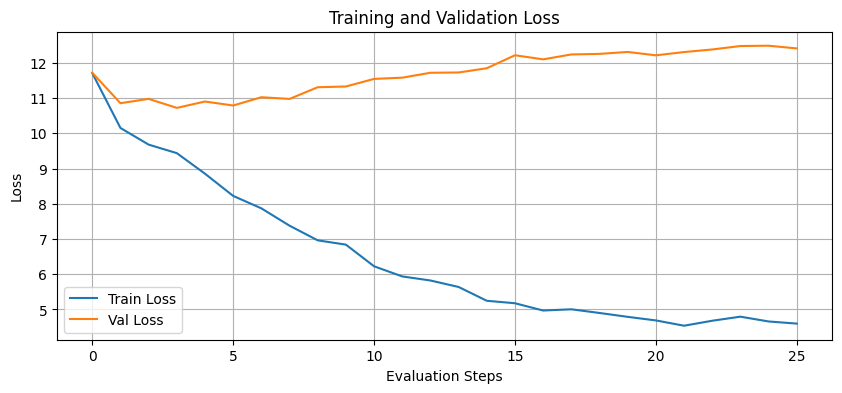


[Sample @ step 25000]: [12687451466135240704, 12686160371585646592, 12687517826064318464, 11919854053611274240, 12687523657556164608, 12687517638159499264, 12687220671772622848, 12687320787460292608, 12711896946273419264, 12687517950618370048]...


100%|██████████| 25001/25001 [53:34<00:00,  7.78it/s]

[Checkpoint] Model saved at step 25000 -> spatial_gpt.pt



[Final] Model saved -> spatial_gpt.pt


In [6]:
block_size=64
model = SpatialGPT(vocab_size=len(vocab_tokens), block_size=block_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
train_losses, val_losses, times = train_spatial_gpt(
    model=model,
    train_data=train_data,
    val_data=val_data,
    vocab_tokens=vocab_tokens,
    batch_size=32,
    steps=25001
)


In [7]:
def s2_to_latlng(s2_id):
    """Converts S2 Cell ID to (lat, lng) in degrees"""
    latlng = CellId(s2_id).to_lat_lng()
    return latlng.lat().degrees, latlng.lng().degrees

def compare_actual_vs_generated(model, train_data, vocab_tokens, block_size=64, max_new_tokens=20):
    # Sample a random seed from train data
    start = torch.randint(0, len(train_data) - block_size, (1,))
    seed = train_data[start:start+block_size].unsqueeze(0).to(device)

    # Actual continuation from ground truth
    actual = train_data[start+block_size:start+block_size+max_new_tokens]

    # Generated continuation
    model.eval()
    with torch.no_grad():
        context = seed.clone()
        for _ in range(max_new_tokens):
            logits = model(context[:, -block_size:])
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            context = torch.cat([context, next_token], dim=1)
        generated = context[0, block_size:]  # skip the seed portion

    # Decode both to lat/lng
    actual_ids = [vocab_tokens[t.item()] for t in actual]
    gen_ids = [vocab_tokens[t.item()] for t in generated]

    actual_coords = [s2_to_latlng(s2) for s2 in actual_ids]
    gen_coords = [s2_to_latlng(s2) for s2 in gen_ids]

    # Plot
    plt.figure(figsize=(8, 6))
    if actual_coords:
        lat_actual, lng_actual = zip(*actual_coords)
        plt.plot(lng_actual, lat_actual, marker='o', label='Actual', color='green')
    if gen_coords:
        lat_gen, lng_gen = zip(*gen_coords)
        plt.plot(lng_gen, lat_gen, marker='x', linestyle='--', label='Generated', color='blue')

    plt.legend()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Actual vs Generated Spatial Path")
    plt.grid(True)
    plt.show()

    # Optional: return the raw values too
    return {
        "actual_tokens": actual.tolist(),
        "generated_tokens": generated.tolist(),
        "actual_coords": actual_coords,
        "generated_coords": gen_coords
    }

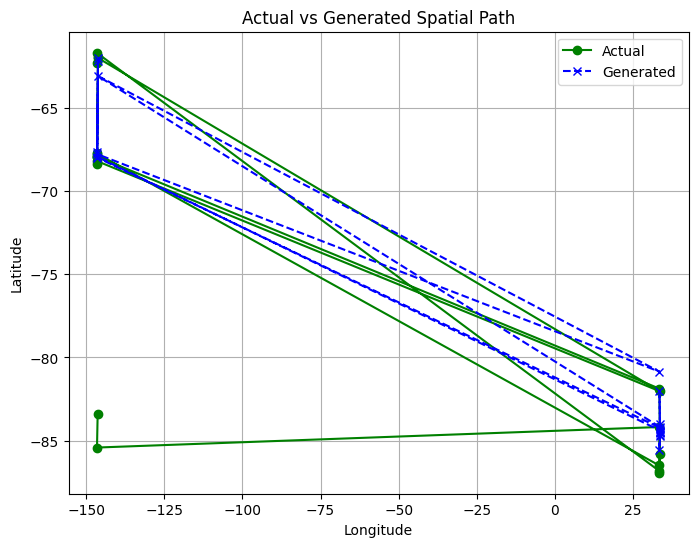

Actual Tokens: [63548, 66671, 39432, 94417, 59507, 39235, 3680, 43647, 97684, 94119, 90791, 60438, 64617, 27565, 61757, 59973, 25516, 11508, 93407, 1627]
Generated Tokens: [92454, 9933, 76837, 95629, 81007, 70093, 74545, 60636, 24601, 86966, 57851, 15223, 51259, 51259, 78074, 97795, 24404, 38831, 87256, 25514]


In [8]:
result = compare_actual_vs_generated(model, train_data, vocab_tokens)

print("Actual Tokens:", result["actual_tokens"])
print("Generated Tokens:", result["generated_tokens"])